In [1]:
# import numpy as np
# from matplotlib import pyplot as plt
# from mdtraj.utils import timing
# #from msmbuilder.example_datasets import load_doublewell
# #from msmbuilder.example_datasets import load_doublewell_Gauss
# #from msmbuilder.example_datasets import load_doublewell_Quart
# #from msmbuilder.cluster import NDGrid
# #from msmbuilder.msm import BayesianMarkovStateModel, MarkovStateModel
# #from msmbuilder.msm import implied_timescales

# import mdtraj as md

# import numpy as np
# import pyemma
# from pyemma.coordinates.api import kmeans, regspace, uniform_time
# from pyemma.msm.analysis import eigenvalues, eigenvectors
# %matplotlib inline


import pyemma
pyemma.__version__

import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import msmbuilder
from msmbuilder.msm.ratematrix import ContinuousTimeMSM
import scipy
from msmtools.analysis.dense.decomposition import eigenvectors, eigenvalues
import operator

Populating the interactive namespace from numpy and matplotlib


/home/theorie/rudzinski/soft/anaconda/envs/PyEmma-new/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/theorie/rudzinski/soft/anaconda/envs/PyEmma-new/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# load the bin data
base_dir = ''
AA_dir = ''
dtraj_dir = ''
bin_dir = ''
#bin_ctrs = np.load(base_dir+'/'+AA_dir+'/'+bin_dir+'/'+'binctrs_50x50bins.dat.npy')
#print bin_ctrs

In [3]:
# load the traj data
#dtraj_AA = pyemma.msm.io.read_discrete_trajectory(base_dir+'/'+AA_dir+'/'+dtraj_dir+'/'+'dih_1-4_scatter.dat')
dtraj_AA = np.squeeze(np.load('../traj/dtraj_CG_1traj_dih_1-4.npy'))
print dtraj_AA.T[:]

[[-179.99675399 -173.74538337 -176.24101564 ...   59.9785398
    57.86982593   56.60576644]
 [   0.962339      1.064359      1.007008   ...    0.700676
     0.695214      0.684847  ]]


In [4]:
#print dtraj_AA[:,1]

Nbins = 50

# ax0 = dih
min_ax0 = min(dtraj_AA[:,0])
max_ax0 = max(dtraj_AA[:,0])
print max_ax0
print min_ax0
centers_ax0 = np.linspace(min_ax0, max_ax0, num=Nbins)
print centers_ax0
# ax1 = 1-4
min_ax1 = min(dtraj_AA[:,1])
max_ax1 = max(dtraj_AA[:,1])
print max_ax1
print min_ax1
centers_ax1 = np.linspace(min_ax1, max_ax1, num=Nbins)
print centers_ax1

centers = [centers_ax0, centers_ax1]
print np.array(centers).shape

# use the AA bin centers instead
centers_new = np.load('binctrs_50x50bins.npy')
print centers

179.9997906647248
-179.99996255206335
[-179.99996255 -172.65302881 -165.30609507 -157.95916133 -150.6122276
 -143.26529386 -135.91836012 -128.57142638 -121.22449264 -113.8775589
 -106.53062516  -99.18369142  -91.83675768  -84.48982394  -77.1428902
  -69.79595647  -62.44902273  -55.10208899  -47.75515525  -40.40822151
  -33.06128777  -25.71435403  -18.36742029  -11.02048655   -3.67355281
    3.67338093   11.02031467   18.3672484    25.71418214   33.06111588
   40.40804962   47.75498336   55.1019171    62.44885084   69.79578458
   77.14271832   84.48965206   91.8365858    99.18351953  106.53045327
  113.87738701  121.22432075  128.57125449  135.91818823  143.26512197
  150.61205571  157.95898945  165.30592319  172.65285693  179.99979066]
1.135793
0.29573
[0.29573    0.31287414 0.33001829 0.34716243 0.36430657 0.38145071
 0.39859486 0.415739   0.43288314 0.45002729 0.46717143 0.48431557
 0.50145971 0.51860386 0.535748   0.55289214 0.57003629 0.58718043
 0.60432457 0.62146871 0.63861286 0.

In [5]:
bin_ctrs = centers[:]
print len(dtraj_AA[:,0])
print dtraj_AA[:,1]
print len(bin_ctrs[0])
print bin_ctrs[0][1] - bin_ctrs[0][0]
print np.floor(bin_ctrs[0][2] - bin_ctrs[0][1])

1000000
[0.962339 1.064359 1.007008 ... 0.700676 0.695214 0.684847]
50
7.346933739118128
7.0


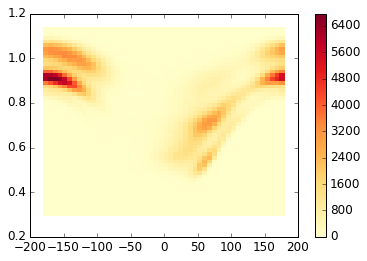

(51,)
(51,)
(50, 50)


In [6]:
# print the histogram of states
dist_AA, xEdges, yEdges = np.histogram2d(dtraj_AA[:,0], dtraj_AA[:,1], len(bin_ctrs[0]) )
#dist_AA,binEdges = np.histogram(dtraj_AA, len(bin_ctrs))
#intl = np.trapz(dist_AA,bin_ctrs)
#dist_AA = np.divide(dist_AA,intl)
#plt.plot(bin_ctrs,dist_AA,'--',linewidth=2.0,color='r')
plt.pcolor(xEdges,yEdges,dist_AA.T,cmap='YlOrRd')
plt.colorbar()
plt.show()

print xEdges.shape
print yEdges.shape
print dist_AA.shape

#plt.axis([-1.05, 1.05, 0.0, 1.2])
#plt.show()

In [7]:
ngridsx = len(bin_ctrs[0])
xmin = min(bin_ctrs[0])
dx = bin_ctrs[0][1] - bin_ctrs[0][0]
ngridsy = len(bin_ctrs[1])
ymin = min(bin_ctrs[1])
dy = bin_ctrs[1][1] - bin_ctrs[1][0]
dtraj_AA_labels = []
xgrid_traj = []
ygrid_traj = []
for i in range(0,len(dtraj_AA[:,0])):
    xgrid_traj.append( int(np.floor( (dtraj_AA[i,0] - xmin) / dx ) ) )
    ygrid_traj.append( int(np.floor( (dtraj_AA[i,1] - ymin) / dy ) ) )
    index = xgrid_traj[i] + ygrid_traj[i]*ngridsx
    dtraj_AA_labels.append(index)

In [8]:
# functions for transforming between bins and labels
def values_to_bins(x,y,xmin,ymin,dx,dy):
    xgrid = int( np.floor( (x - xmin) / dx ) ) 
    ygrid = int( np.floor( (y - ymin) / dy ) ) 
    return xgrid, ygrid

def bins_to_label(xgrid,ygrid,nx):
    label = xgrid + ygrid*nx 
    return label

def label_to_bins(label,nx):
    xgrid = label % nx
    ygrid = (label - xgrid) / nx
    return xgrid, ygrid

def bins_to_values(xgrid, ygrid, values):
    values_x = values[0][xgrid]
    values_y = values[1][ygrid]
    return values_x, values_y

In [9]:
tau = 3
Cmat_AA = pyemma.msm.estimation.count_matrix(dtraj_AA_labels, tau, sliding=False, sparse_return=False, nstates=None)
print pyemma.msm.estimation.is_connected(Cmat_AA, directed=True)
lcc_AA = pyemma.msm.estimation.largest_connected_set(Cmat_AA, directed=True)
Cmat_AA_cc = pyemma.msm.estimation.largest_connected_submatrix(Cmat_AA, directed=True, lcc=lcc_AA)
print lcc_AA

False
[  26  127  173 ... 2405 2447 2448]


In [10]:
#bin_ctrs_AA_cc = [bin_ctrs[i] for i in lcc_AA]
#bin_ctrs_AA_cc = np.array(bin_ctrs_AA_cc)
#print bin_ctrs
#print bin_ctrs_AA_cc

lcc_trim_AA = lcc_AA[:]
minsamp = np.sum(Cmat_AA_cc) / (100.0*lcc_AA.size)
nrem = 0
for i in range(0,lcc_AA.size):
    shift = i - nrem
    if ( np.sum(Cmat_AA_cc[shift]) < minsamp ): # trim from matrix and bins
        Cmat_AA_cc = np.delete(Cmat_AA_cc, (shift), axis=0)
        Cmat_AA_cc = np.delete(Cmat_AA_cc, (shift), axis=1)
        lcc_trim_AA = np.delete(lcc_trim_AA, (shift))
        nrem += 1
        
xgrids_trim, ygrids_trim = label_to_bins(lcc_trim_AA,ngridsx)
bin_ctrs_x_trim, bin_ctrs_y_trim = bins_to_values(xgrids_trim, ygrids_trim, bin_ctrs)
#plt.pcolor(lcc_trim_AA,lcc_trim_AA,Cmat_AA_cc,cmap='Blues')
#plt.colorbar()
#plt.show()

#print xgrids_trim
#print ygrids_trim
#print bin_ctrs_x_trim
#print bin_ctrs_y_trim

In [11]:
lcc_AA_tmp = pyemma.msm.estimation.largest_connected_set(Cmat_AA_cc, directed=True)
Cmat_AA_cc = pyemma.msm.estimation.largest_connected_submatrix(Cmat_AA_cc, directed=True, lcc=lcc_AA_tmp)
lcc_trim_AA = lcc_trim_AA[lcc_AA_tmp]

xgrids_trim, ygrids_trim = label_to_bins(lcc_trim_AA,ngridsx)
bin_ctrs_x_trim, bin_ctrs_y_trim = bins_to_values(xgrids_trim, ygrids_trim, bin_ctrs)

In [12]:
T_AA, pi_AA = pyemma.msm.estimation.transition_matrix(Cmat_AA_cc, reversible=True, mu=None, return_statdist=True)

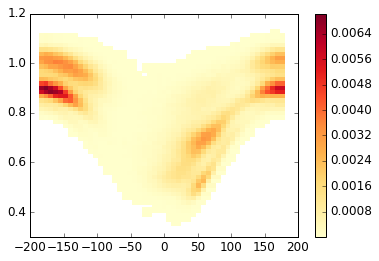

In [13]:
plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=pi_AA,cmap='YlOrRd',marker='s',linewidth=0.0)
plt.colorbar()
plt.show()
#print bin_ctrs_x_trim
#print lcc_trim_AA.shape
#print bin_ctrs_y_trim.shape
#print pi_AA.shape

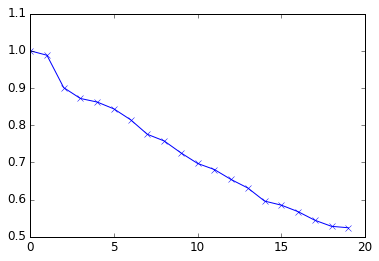

In [14]:
evals = eigenvalues(T_AA,k=20)
plt.plot(np.real(evals),marker='x')
#plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=pi_AA,cmap='YlOrRd',marker='s',linewidth=0.0)
#plt.colorbar()
#plt.show()


In [15]:
ts_est = pyemma.msm.analysis.dense.decomposition.timescales(T_AA)
print ts_est[1:5]
print len(dtraj_AA)

[83.44803258  9.5954705   7.28948749  6.74818183]
1000000


In [16]:
ts_f_tau = []
tau = np.linspace(1,20,20,dtype=int)
for lag in tau:
    Cmat_AA = pyemma.msm.estimation.count_matrix(dtraj_AA_labels, lag, sliding=True, sparse_return=False, nstates=None)
    lcc_AA = pyemma.msm.estimation.largest_connected_set(Cmat_AA, directed=True)
    Cmat_AA_cc = pyemma.msm.estimation.largest_connected_submatrix(Cmat_AA, directed=True, lcc=lcc_AA)
    lcc_trim_AA = lcc_AA[:]
    minsamp = np.sum(Cmat_AA_cc) / (100.0*lcc_AA.size)
    nrem = 0
    for i in range(0,lcc_AA.size):
        shift = i - nrem
        if ( np.sum(Cmat_AA_cc[shift]) < minsamp ): # trim from matrix and bins
            Cmat_AA_cc = np.delete(Cmat_AA_cc, (shift), axis=0)
            Cmat_AA_cc = np.delete(Cmat_AA_cc, (shift), axis=1)
            lcc_trim_AA = np.delete(lcc_trim_AA, (shift))
            nrem += 1
    lcc_AA_tmp = pyemma.msm.estimation.largest_connected_set(Cmat_AA_cc, directed=True)
    Cmat_AA_cc = pyemma.msm.estimation.largest_connected_submatrix(Cmat_AA_cc, directed=True, lcc=lcc_AA_tmp)
    lcc_trim_AA = lcc_trim_AA[lcc_AA_tmp]
    T_AA, pi_AA = pyemma.msm.estimation.transition_matrix(Cmat_AA_cc, reversible=True, mu=None, return_statdist=True)
    ts_est = pyemma.msm.analysis.dense.decomposition.timescales(T_AA)
    ts_f_tau.append(ts_est[1:5])
ts_f_tau = np.array(ts_f_tau)

In [17]:
print ts_f_tau[0,:]
print ts_f_tau[:,0]
print ts_f_tau[:,:]

[526.50772626  64.54886554  44.52388568  36.05184175]
[526.50772626 164.27634716  82.8576217   52.66011174  38.02376396
  29.83796438  24.7173774   21.30506378  18.89763632  17.12465564
  15.77717073  14.72781067  13.89016181  13.21092322  12.64817339
  12.17064809  11.75868212  11.39756097  11.07770932  10.7928297 ]
[[526.50772626  64.54886554  44.52388568  36.05184175]
 [164.27634716  19.42389049  13.79054303  13.0016996 ]
 [ 82.8576217    9.57369136   7.27447376   6.75495054]
 [ 52.66011174   6.09906284   5.11109207   4.40685286]
 [ 38.02376396   4.45720063   4.02575331   3.17223155]
 [ 29.83796438   3.54590092   3.35428024   2.46699386]
 [ 24.7173774    3.02446074   2.89500518   2.06289371]
 [ 21.30506378   2.69530375   2.56677086   1.81475763]
 [ 18.89763632   2.4558271    2.32698128   1.63762157]
 [ 17.12465564   2.25583941   2.12901271   1.49618316]
 [ 15.77717073   2.09714803   1.97051362   1.37853979]
 [ 14.72781067   1.97179343   1.84134954   1.28119315]
 [ 13.89016181   1.86

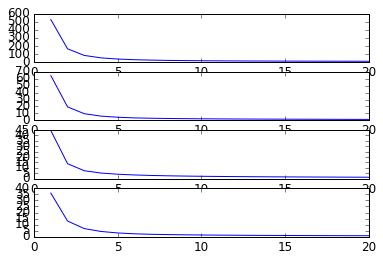

In [18]:
fig = plt.figure(1)
plt.subplot(4,1,1)
plt.plot(tau,ts_f_tau[:,0])
plt.subplot(4,1,2)
plt.plot(tau,ts_f_tau[:,1])
plt.subplot(4,1,3)
plt.plot(tau,ts_f_tau[:,2])
plt.subplot(4,1,4)
plt.plot(tau,ts_f_tau[:,3])

In [21]:
tau = np.linspace(1,50,20,dtype=int)
its_full = msm.timescales_msm(dtraj_AA_labels, lags=tau, nits=6)

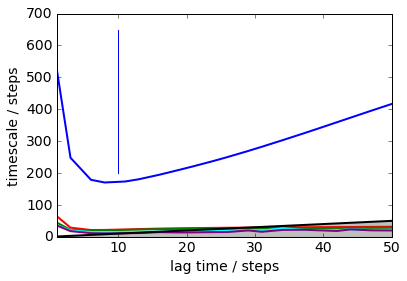

In [22]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its_full, ylog=False, units='steps', linewidth=2)
plt.plot(10.*np.ones(10),np.arange(10)*50+200)
#xlim(0, 10); ylim(0, 100);

In [23]:
tau = 10
Cmat_AA = pyemma.msm.estimation.count_matrix(dtraj_AA_labels, tau, sliding=True, sparse_return=False, nstates=None)
print pyemma.msm.estimation.is_connected(Cmat_AA, directed=True)
lcc_AA = pyemma.msm.estimation.largest_connected_set(Cmat_AA, directed=True)
Cmat_AA_cc = pyemma.msm.estimation.largest_connected_submatrix(Cmat_AA, directed=True, lcc=lcc_AA)

False


In [24]:
#bin_ctrs_AA_cc = [bin_ctrs[i] for i in lcc_AA]
#bin_ctrs_AA_cc = np.array(bin_ctrs_AA_cc)
#print bin_ctrs
#print bin_ctrs_AA_cc

lcc_trim_AA = lcc_AA[:]
minsamp = np.sum(Cmat_AA_cc) / (100.0*lcc_AA.size)
nrem = 0
for i in range(0,lcc_AA.size):
    shift = i - nrem
    if ( np.sum(Cmat_AA_cc[shift]) < minsamp ): # trim from matrix and bins
        Cmat_AA_cc = np.delete(Cmat_AA_cc, (shift), axis=0)
        Cmat_AA_cc = np.delete(Cmat_AA_cc, (shift), axis=1)
        lcc_trim_AA = np.delete(lcc_trim_AA, (shift))
        nrem += 1
        
lcc_AA_tmp = pyemma.msm.estimation.largest_connected_set(Cmat_AA_cc, directed=True)
Cmat_AA_cc = pyemma.msm.estimation.largest_connected_submatrix(Cmat_AA_cc, directed=True, lcc=lcc_AA_tmp)
lcc_trim_AA = lcc_trim_AA[lcc_AA_tmp]

xgrids_trim, ygrids_trim = label_to_bins(lcc_trim_AA,ngridsx)
bin_ctrs_x_trim, bin_ctrs_y_trim = bins_to_values(xgrids_trim, ygrids_trim, bin_ctrs)

In [25]:
T_AA, pi_AA = pyemma.msm.estimation.transition_matrix(Cmat_AA_cc, reversible=True, mu=None, return_statdist=True)

In [26]:
# save the model
np.save('T',T_AA)
np.save('mu',pi_AA)
np.save('tau',tau)
np.save('grids_trim',np.array([xgrids_trim,ygrids_trim]))
np.save('bin_ctrs_trim',np.array([bin_ctrs_x_trim,bin_ctrs_y_trim]))
np.save('lcc_trim',lcc_trim_AA)

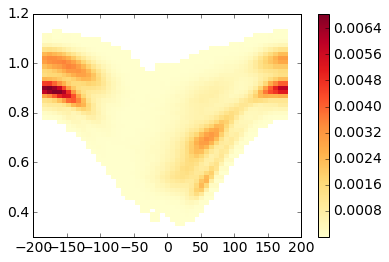

In [27]:
plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=pi_AA,cmap='YlOrRd',marker='s',linewidth=0.0)
plt.colorbar()
plt.show()

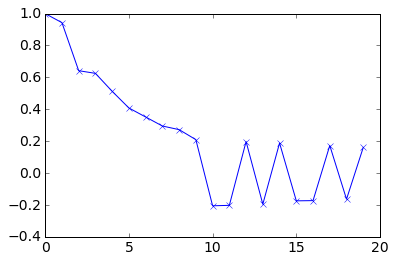

In [28]:
evals = eigenvalues(T_AA,k=20)
plt.plot(np.real(evals),marker='x')

In [29]:
evecs = eigenvectors(T_AA,k=20)

In [30]:
#print evecs[:,1]

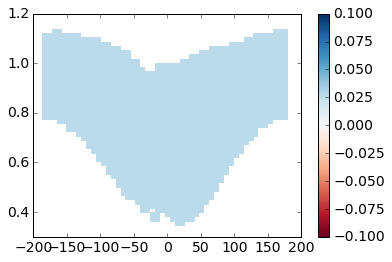

In [31]:
plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=evecs[:,0],cmap='RdBu',marker='s',linewidth=0.0,vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.show()

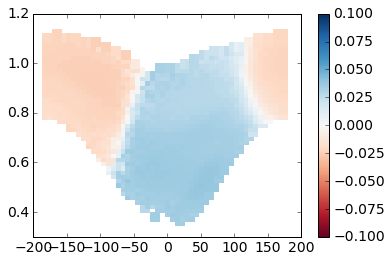

In [32]:
plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=evecs[:,1],cmap='RdBu',marker='s',linewidth=0.0,vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.show()

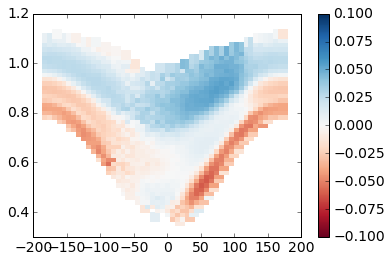

In [33]:
plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=evecs[:,2],cmap='RdBu',marker='s',linewidth=0.0,vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.show()

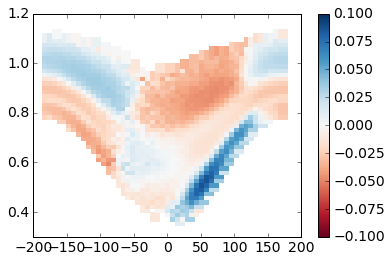

In [34]:
plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=evecs[:,3],cmap='RdBu',marker='s',linewidth=0.0,vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.show()

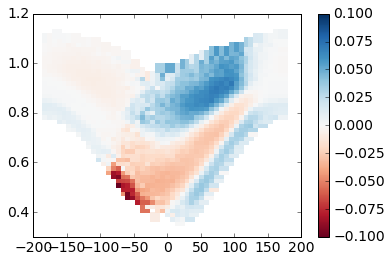

In [35]:
plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=evecs[:,4],cmap='RdBu',marker='s',linewidth=0.0,vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.show()

In [36]:
from pyemma.msm import PCCA

In [37]:
pcca=PCCA(T_AA, 4)

In [38]:
membership_crisp=np.where(pcca.memberships>0.5)

In [39]:
#print membership_crisp[0]
membership = pcca.memberships

In [40]:
#print list(set(t) - set(s))  bin_ctrs_x_trim
#print bin_ctrs_y_trim
centers = [np.sort(list(set(bin_ctrs_x_trim))),np.sort(list(set(bin_ctrs_y_trim)))]
print centers[0]
print centers[1]

[-179.99996255 -172.65302881 -165.30609507 -157.95916133 -150.6122276
 -143.26529386 -135.91836012 -128.57142638 -121.22449264 -113.8775589
 -106.53062516  -99.18369142  -91.83675768  -84.48982394  -77.1428902
  -69.79595647  -62.44902273  -55.10208899  -47.75515525  -40.40822151
  -33.06128777  -25.71435403  -18.36742029  -11.02048655   -3.67355281
    3.67338093   11.02031467   18.3672484    25.71418214   33.06111588
   40.40804962   47.75498336   55.1019171    62.44885084   69.79578458
   77.14271832   84.48965206   91.8365858    99.18351953  106.53045327
  113.87738701  121.22432075  128.57125449  135.91818823  143.26512197
  150.61205571  157.95898945  165.30592319  172.65285693]
[0.36430657 0.38145071 0.39859486 0.415739   0.43288314 0.45002729
 0.46717143 0.48431557 0.50145971 0.51860386 0.535748   0.55289214
 0.57003629 0.58718043 0.60432457 0.62146871 0.63861286 0.655757
 0.67290114 0.69004529 0.70718943 0.72433357 0.74147771 0.75862186
 0.775766   0.79291014 0.81005429 0.8271

In [41]:
print centers[0].size
print centers[1].size
print T_AA.shape
print bin_ctrs_x_trim.size
print membership[:,0]
#pi_AA_M = np.reshape(pi_AA, (centers[0].size,centers[1].size))

49
45
(1351, 1351)
1351
[0.41644881 0.3081411  0.52066295 ... 0.00326149 0.01195833 0.019376  ]


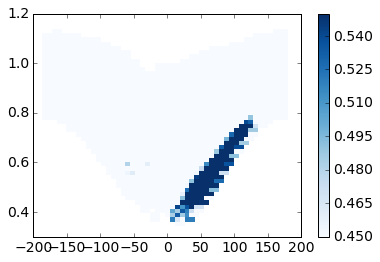

In [42]:
plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=membership[:,0],cmap='Blues',marker='s',linewidth=0.0,vmin=0.5,vmax=0.5)
plt.colorbar()
plt.show()

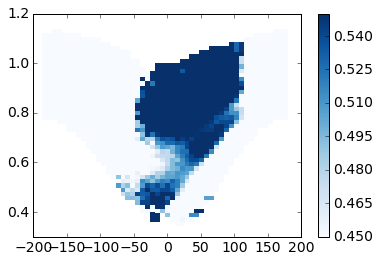

In [43]:
plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=membership[:,1],cmap='Blues',marker='s',linewidth=0.0,vmin=0.5,vmax=0.5)
plt.colorbar()
plt.show()

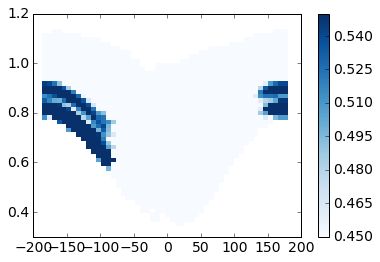

In [44]:
plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=membership[:,2],cmap='Blues',marker='s',linewidth=0.0,vmin=0.5,vmax=0.5)
plt.colorbar()
plt.show()

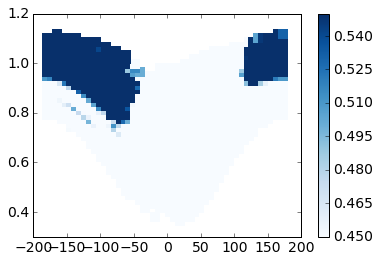

In [45]:
plt.scatter(bin_ctrs_x_trim, bin_ctrs_y_trim,s=100,c=membership[:,3],cmap='Blues',marker='s',linewidth=0.0,vmin=0.5,vmax=0.5)
plt.colorbar()
plt.show()

In [46]:
# define the metastable states by label
E2 = np.where(membership[:,0]>0.5)
E1 = np.where(membership[:,1]>0.5)
H = np.where(membership[:,2]>0.5)
I = np.where(membership[:,3]>0.5)

In [47]:
# make sure there is no overlap
check = [val for val in E2[0] if val in I[0]]
print check 
check = [val for val in E2[0] if val in E1[0]]
print check 
check = [val for val in E2[0] if val in H[0]]
print check 

[]
[]
[]


In [48]:
# get the grids for each set
xgrids_I, ygrids_I = label_to_bins(lcc_trim_AA[I[0]],ngridsx)
bin_ctrs_x_I, bin_ctrs_y_I = bins_to_values(xgrids_I, ygrids_I, bin_ctrs)

xgrids_E2, ygrids_E2 = label_to_bins(lcc_trim_AA[E2[0]],ngridsx)
bin_ctrs_x_E2, bin_ctrs_y_E2 = bins_to_values(xgrids_E2, ygrids_E2, bin_ctrs)

xgrids_H, ygrids_H = label_to_bins(lcc_trim_AA[H[0]],ngridsx)
bin_ctrs_x_H, bin_ctrs_y_H = bins_to_values(xgrids_H, ygrids_H, bin_ctrs)

xgrids_E1, ygrids_E1 = label_to_bins(lcc_trim_AA[E1[0]],ngridsx)
bin_ctrs_x_E1, bin_ctrs_y_E1 = bins_to_values(xgrids_E1, ygrids_E1, bin_ctrs)

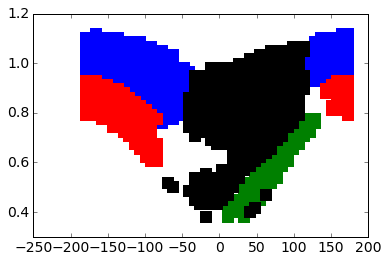

In [49]:
plt.scatter(bin_ctrs_x_I, bin_ctrs_y_I,color='b',s=150,marker='s',linewidth=0.0)
plt.scatter(bin_ctrs_x_E2, bin_ctrs_y_E2,color='g',s=150,marker='s',linewidth=0.0)
plt.scatter(bin_ctrs_x_H, bin_ctrs_y_H,color='r',s=150,marker='s',linewidth=0.0)
plt.scatter(bin_ctrs_x_E1, bin_ctrs_y_E1,color='k',s=150,marker='s',linewidth=0.0)
plt.show()

In [50]:
#from pyemma.msm.analysis import mfpt
from msmtools.analysis import mfpt

In [51]:
m_t_H_I = mfpt(T_AA,I[0],origin=H[0])
m_t_H_E1 = mfpt(T_AA,E1[0],origin=H[0])
m_t_H_E2 = mfpt(T_AA,E2[0],origin=H[0])

m_t_I_E1 = mfpt(T_AA,E1[0],origin=I[0])
m_t_I_E2 = mfpt(T_AA,E2[0],origin=I[0])
m_t_I_H = mfpt(T_AA,H[0],origin=I[0])

m_t_E1_E2 = mfpt(T_AA,E2[0],origin=E1[0])
m_t_E1_I = mfpt(T_AA,I[0],origin=E1[0])
m_t_E1_H = mfpt(T_AA,H[0],origin=E1[0])

m_t_E2_E1 = mfpt(T_AA,E1[0],origin=E2[0])
m_t_E2_I = mfpt(T_AA,I[0],origin=E2[0])
m_t_E2_H = mfpt(T_AA,H[0],origin=E2[0])

In [52]:
print m_t_H_I 
print m_t_H_E1 
print m_t_H_E2
print '\n'
print m_t_I_E1 
print m_t_I_E2 
print m_t_I_H 
print '\n'
print m_t_E1_E2 
print m_t_E1_I 
print m_t_E1_H 
print '\n'
print m_t_E2_E1 
print m_t_E2_I 
print m_t_E2_H 

7.582681643333385
43.84156785676801
78.56143596859962


44.853966823406644
80.3137684153267
8.736221959858002


38.53662732610949
31.62248873725144
32.33511508777135


7.087881852992969
33.87768432125927
33.876966855900285
